In [1]:
from ode import RungeKuttaVector
import numpy as np
from numpy import array, dot, sin, cos
import matplotlib.pyplot as plt

# Task 1

In [2]:
def euler(F, y_0, t_span, m=1, dt=1e-3):
    solution = [y_0]
    t_0, t_end = t_span

    solution_t = [t_0]

    t = t_0 + dt

    while(t < t_end):
        r = solution[-1][:2]
        p = solution[-1][2:]

        v = p/m

        next_r = r + v*dt + 1/2 *F(t,r)/m *dt**2
        next_p = p + F(t, r) * dt

        solution.append(np.concatenate((next_r, next_p)))
        solution_t.append(t)

        t+= dt

    return array(solution_t), array(solution)




In [3]:
def verlet(F, y0, t_span,m, dt, r_dim=2, calc_v = True, arg_velocity=False):
    next_r = y0[:r_dim]  - y0[r_dim:]*dt / m

    t0, t_end = t_span
    t = t0

    solution = [next_r, y0[:r_dim]]
    solution_time = [t-dt, t]

    t = t0 + dt

    while t < t_end:
        r_next = 2*solution[-1] - solution[-2] + F(t, solution[-1])/m * dt**2
        solution_time.append(t)
        solution.append(r_next)
        t += dt
    
    if not calc_v: return np.array(solution_time), np.array(solution)

    solution_with_v = [y0]

    for i, r in enumerate(solution[:-1]):
        if i == 0: continue

        v = 1/2/dt * (solution[i+1] - solution[i-1])

        solution_with_v.append(np.concatenate((r, v*m)))

    sol_time = array(solution_time[:-1])
    sol_with_v = array(solution_with_v)

    return sol_time, sol_with_v



In [4]:
def leapfrog(F, y0, t_span,m, dt):
    r, v = y0[:2], y0[2:]/m

    sol_r = [r]
    sol_v = [v]

    t, t_end = t_span
    sol_t = [t]
    t += dt
    sollution = [y_0]

    while t < t_end:
        next_v = sol_v[-1] + F(t, sol_r[-1])/m*dt

        next_r = sol_r[-1] + next_v*dt

        sol_r.append(next_r)
        sol_v.append(next_v)
        sol_t.append(t)

        sollution.append(np.concatenate((next_r, next_v*m)))
        t += dt

    return array(sol_t), array(sollution)

In [5]:
def get_energy(solution, potential, m):
    energy_kinetic = []
    energy_potential = []

    for y in solution:
        E_k = dot(y[2:], y[2:]) / 2 / m
        E_p = potential(y[:2]) * m

        energy_kinetic.append(E_k)
        energy_potential.append(E_p)

    energy_kinetic = array(energy_kinetic)
    energy_potential = array(energy_potential)

    energy_total = energy_kinetic + energy_potential

    return energy_kinetic, energy_potential, energy_total


SyntaxError: invalid syntax (<ipython-input-5-f395f59e1728>, line 7)

In [82]:
def solve_and_print(consts, y0, method, t_span, do_energy=True):
    G, M, m, dt = consts

    force = lambda _, r: -G *M *m * r / np.linalg.norm(r)**3
    potential = lambda r: -G*M / np.linalg.norm(r)
    
    sol_t, sol = method(force, y0, t_span,m, dt)


    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.title('position - ' + method.__name__)
    plt.plot(sol[:, 0], sol[:, 1], c='r')
    
    if not do_energy: return


    ek, ep, et = get_energy(sol, potential, m)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['kinetic', 'potential', 'total energy']
    for i, ax in enumerate(axs): ax.set_title(titles[i])

    for ax in axs: ax.grid(True)
    axs[0].plot(sol_t, ek )
    axs[1].plot(sol_t, ep)
    axs[2].plot(sol_t, et)

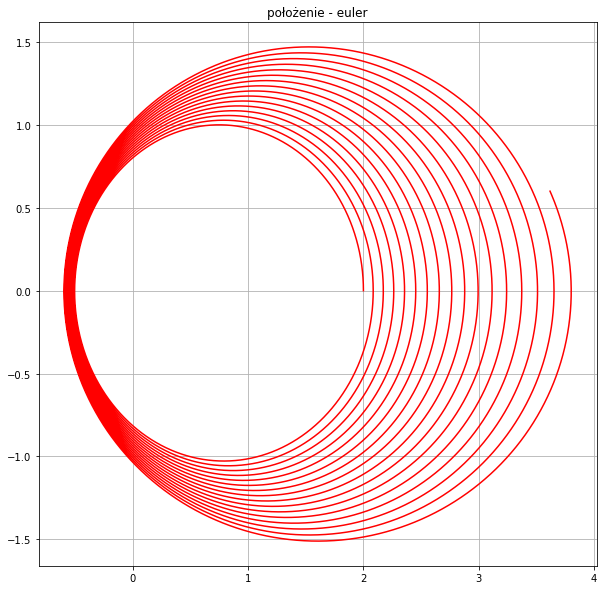

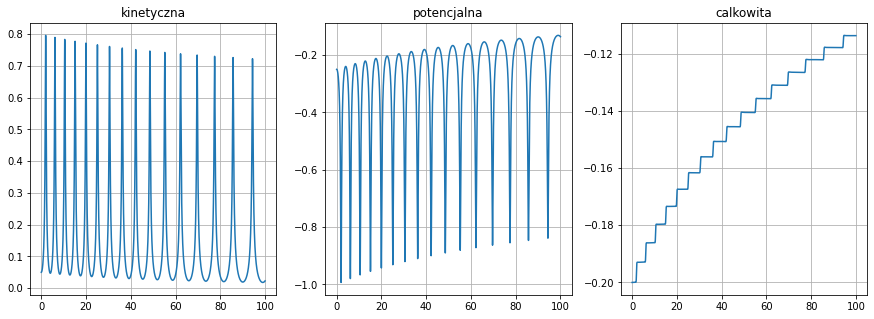

In [83]:

G = 0.01
M = 500
m = 0.1
dt = 1e-3

y_0 = array((2., 0., 0, 0.1))

const = (G, M, m, dt)

solve_and_print(const, y_0, euler, (0,100))

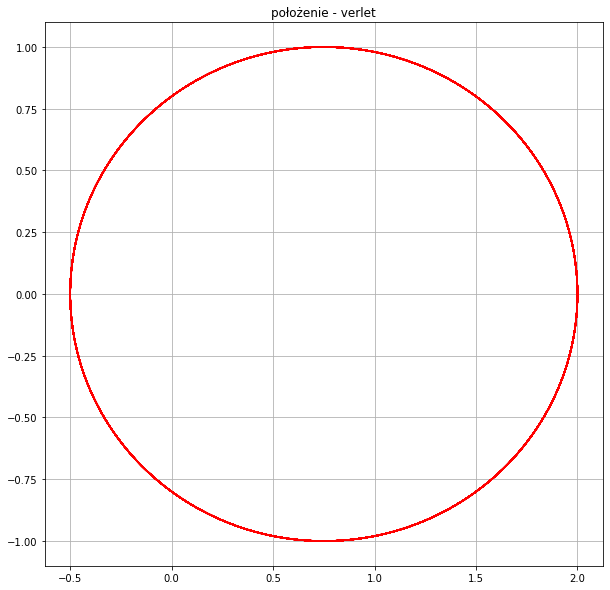

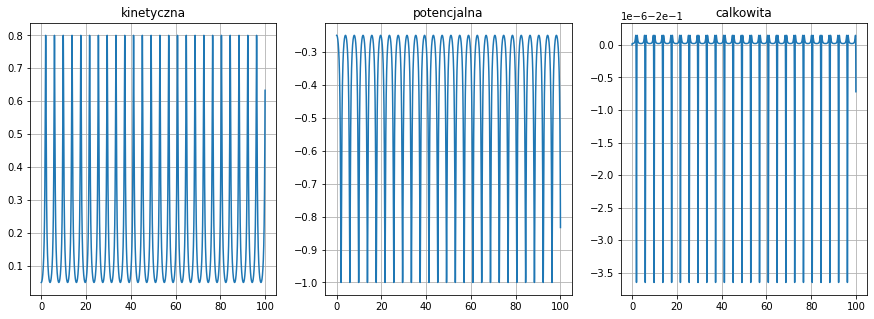

In [107]:
solve_and_print(const, y_0, verlet, (0,100))

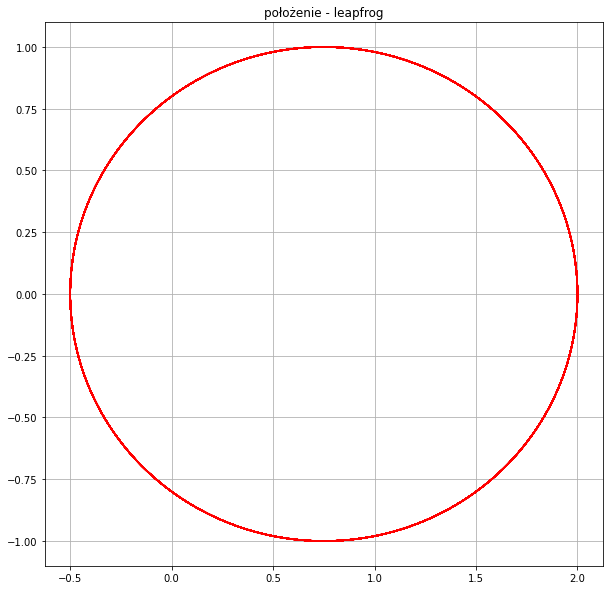

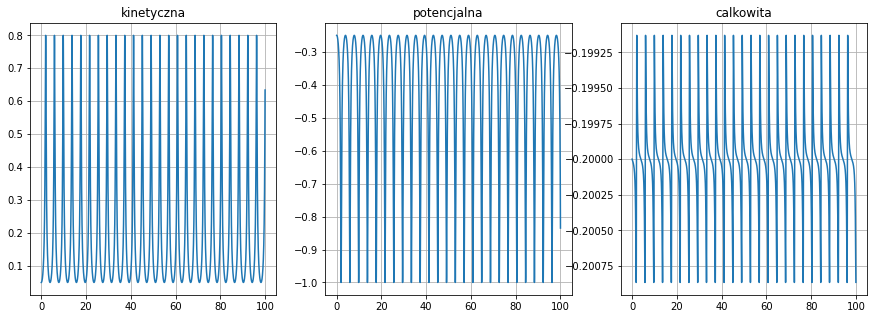

In [113]:
solve_and_print(const, y_0, leapfrog, (0,100))

# Task 3

In [114]:

def force_n_bodies(R, masses, n, dim=2, G=1e-2):

    def get_n_r(n):
        return R[n*dim:(n+1)*dim]

    R_copy = copy(R)

    forces = []
    for i in range(n):
        r_self = get_n_r(i)

        F = np.zeros(dim)

        for j in range(n):
            if i == j:
                continue

            r_other = get_n_r(j)

            F += (r_other - r_self) * G * \
                masses[i] * masses[j] / np.linalg.norm(r_other - r_self)**3

        forces.append(F)
    assert (R == R_copy).all(), 'R has changed'
    return np.concatenate(forces)

In [150]:
r1 = array((0.97000436,
            -0.24308753))
r2 = -1*r1
r3 = array((0., 0.))
v3 = array((0.93240737, 0.86473146))
v1 = -0.5*v3
v2 = -0.5*v3

y0 = np.concatenate((r1, r2, r3, v1, v2, v3))
y0

array([ 0.97000436, -0.24308753, -0.97000436,  0.24308753,  0.        ,
        0.        , -0.46620368, -0.43236573, -0.46620368, -0.43236573,
        0.93240737,  0.86473146])

(-1.1897161134418996,
 1.189715906139829,
 -0.39467078027191327,
 0.3947782646541988)

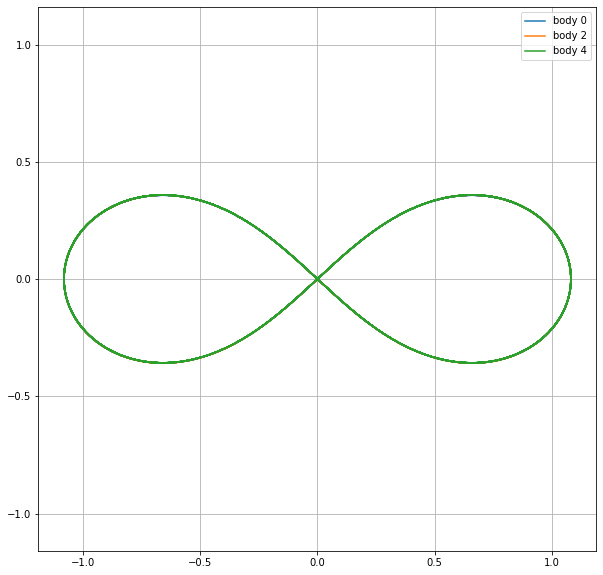

In [154]:
def force(_, r):
    return force_n_bodies(r, [1, 1, 1], 3, G = 1)


sol_t, sol = verlet(force, y0, (0, 1e2), 1, 1e-3, 6, calc_v=False)


plt.figure(figsize=(10, 10))

for i in range(0, 6, 2): plt.plot(sol[:,i], sol[:, i+1], label='body ' + str(i))
plt.legend()
plt.grid(True)
plt.axis('equal')
